In [1]:
import keras.models
import tensorflow as tf
import keras.layers as layers
from keras.callbacks import EarlyStopping
import math
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print(tf.__version__)

2.9.0


## Dataset formatting

In [3]:
# Define the path to the directory containing the images
image_dir_train = '../chest_xray/train/'
image_dir_test = '../chest_xray/test/'

# Define the batch size and image size for the dataset
batch_size = 32
img_size = (224, 224)

# Use the tf.keras.preprocessing.image_dataset_from_directory function to create the dataset
print("training set")
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir_train,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir_train,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)

print("test set")
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir_test,
    batch_size=batch_size,
    image_size=img_size,
    seed=123,
    shuffle=True,
)

training set
Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Metal device set to: Apple M1 Pro


2023-04-18 16:37:53.522946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-18 16:37:53.523143: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
test set
Found 624 files belonging to 2 classes.


In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with data augmentation and validation_split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # Use 20% of the data for validation

# Use flow_from_directory method to load images and apply data augmentation for the training set
train_generator = datagen.flow_from_directory(
    image_dir_train,  # Directory containing all images
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')  # Use the 'training' subset

# Use flow_from_directory method to load images without data augmentation for the validation set
val_generator = datagen.flow_from_directory(
    image_dir_train,  # Directory containing all images
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')  # Use the 'validation' subset

test_datagen = ImageDataGenerator(
    rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    image_dir_test,  # Directory containing all images
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

train_steps_per_epoch = math.ceil(train_generator.n / train_generator.batch_size)
val_steps_per_epoch = math.ceil(val_generator.n / val_generator.batch_size)

print("train dataset images:", train_generator.n)
print("validation dataset images:", val_generator.n)
print("test dataset images:", test_generator.n)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
train dataset images: 4187
validation dataset images: 1045
test dataset images: 624


In [5]:
# Preprocessing

# Normalizing pixel values
train_dataset = train_dataset.map(lambda x, y: (x/255.0, y))
validation_dataset = validation_dataset.map(lambda x, y: (x/255.0, y))
test_dataset = test_dataset.map(lambda x, y: (x/255.0, y))

## Making model

In [9]:
model = keras.models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

## Training model

In [11]:
# Train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping])



Epoch 1/100


2023-04-16 20:24:24.501533: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-16 20:24:24.936043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.5691 - accuracy: 0.7313

2023-04-16 20:25:08.304469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 54s 407ms/step - loss: 0.5691 - accuracy: 0.7313 - val_loss: 0.5088 - val_accuracy: 0.7426
Epoch 2/100
131/131 [==============================] - 50s 384ms/step - loss: 0.4790 - accuracy: 0.7425 - val_loss: 0.4229 - val_accuracy: 0.7426
Epoch 3/100
131/131 [==============================] - 50s 384ms/step - loss: 0.4262 - accuracy: 0.7784 - val_loss: 0.3561 - val_accuracy: 0.8077
Epoch 4/100
131/131 [==============================] - 51s 389ms/step - loss: 0.3352 - accuracy: 0.8464 - val_loss: 0.5791 - val_accuracy: 0.7751
Epoch 5/100
131/131 [==============================] - 51s 387ms/step - loss: 0.3286 - accuracy: 0.8503 - val_loss: 0.3841 - val_accuracy: 0.8182
Epoch 6/100
131/131 [==============================] - 50s 384ms/step - loss: 0.3094 - accuracy: 0.8631 - val_loss: 0.4469 - val_accuracy: 0.8010
Epoch 7/100
131/131 [==============================] - 52s 393ms/step - loss: 0.2971 - accuracy: 0.8703 - val_loss: 0.3085 - val_accurac

In [6]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print('Test accuracy:', test_accuracy)

NameError: name 'model' is not defined

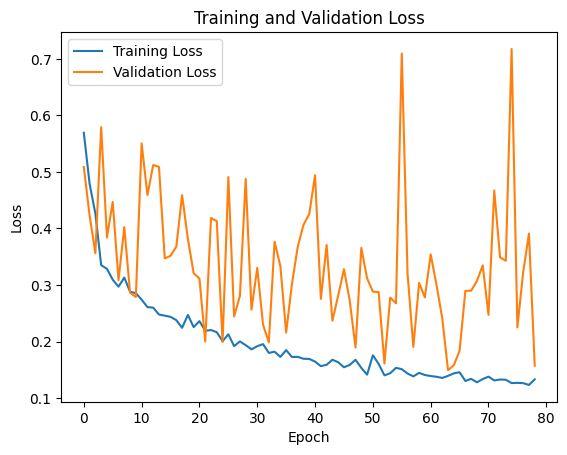

In [13]:
# Extract the metrics from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

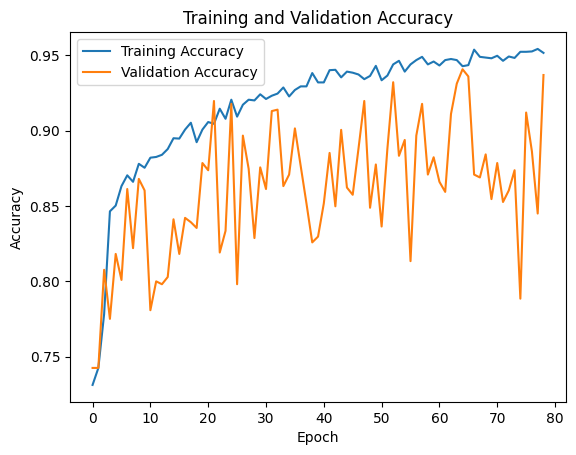

In [14]:
# Plot training and validation accuracy
plt.figure()
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
oldModel = keras.models.load_model('models/my_custom_model.h5')
old_test_loss, old_test_accuracy = oldModel.evaluate(test_generator)

if old_test_accuracy < test_accuracy:
    model.save('models/my_custom_model.h5')

2023-04-20 14:37:24.517294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 3s 159ms/step - loss: 0.2324 - accuracy: 0.9199


NameError: name 'test_accuracy' is not defined

In [7]:
import copy
oldModel = keras.models.load_model('models/my_custom_model.h5')
old_test_loss, old_test_accuracy = oldModel.evaluate(test_generator)

newOldModel = copy.deepcopy(oldModel)

2023-04-18 16:38:21.820503: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-18 16:38:21.887369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 4s 165ms/step - loss: 0.2425 - accuracy: 0.9103


INFO:tensorflow:Assets written to: ram://bfb516ea-51ce-4e40-9039-f8ef95446ae2/assets


INFO:tensorflow:Assets written to: ram://bfb516ea-51ce-4e40-9039-f8ef95446ae2/assets


In [8]:
oldModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

In [ ]:


oldModel = keras.models.load_model('models/my_custom_model.h5')

# Train the model
newOldModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = newOldModel.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=500,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping])

Epoch 1/500


2023-04-18 16:38:52.215065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9412

2023-04-18 16:39:38.906105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 57s 418ms/step - loss: 0.1526 - accuracy: 0.9412 - val_loss: 0.2573 - val_accuracy: 0.9167
Epoch 2/500
131/131 [==============================] - 53s 402ms/step - loss: 0.1624 - accuracy: 0.9403 - val_loss: 0.2121 - val_accuracy: 0.9234
Epoch 3/500
131/131 [==============================] - 53s 402ms/step - loss: 0.1653 - accuracy: 0.9386 - val_loss: 0.1840 - val_accuracy: 0.9196
Epoch 4/500
131/131 [==============================] - 52s 400ms/step - loss: 0.1608 - accuracy: 0.9441 - val_loss: 0.4666 - val_accuracy: 0.8976
Epoch 5/500
131/131 [==============================] - 53s 403ms/step - loss: 0.1523 - accuracy: 0.9448 - val_loss: 0.1593 - val_accuracy: 0.9359
Epoch 6/500
131/131 [==============================] - 52s 400ms/step - loss: 0.1374 - accuracy: 0.9467 - val_loss: 0.3436 - val_accuracy: 0.9167
Epoch 7/500
131/131 [==============================] - 52s 400ms/step - loss: 0.1500 - accuracy: 0.9439 - val_loss: 0.1748 - val_accurac

In [ ]:
newOldModel.evaluate(test_generator)